In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import networkx as nx
import choix

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


In [3]:
# round design variables

# design the distribution of expertise for voters
# the approach here is to use the beta-distribution as a way to generate a distribution of expertise,
#  with several parameters mapping to low, medium, and high expertise
# We then draw from this distribution to assign expertise to each voter
expertise2params = {
    'very-low': (1, 6),
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'very-high': (6, 1)
}
simulation_badgeholder_expertise = 'very-high'

# similar to the above, define a distribution of project impact.
impact2params = {
    'low': (1, 2),
    'medium': (2, 2),
    'high': (2, 1)
}
simulation_project_impact = 'high'

# the random generator object
SEED=1234
rng = np.random.default_rng(SEED)

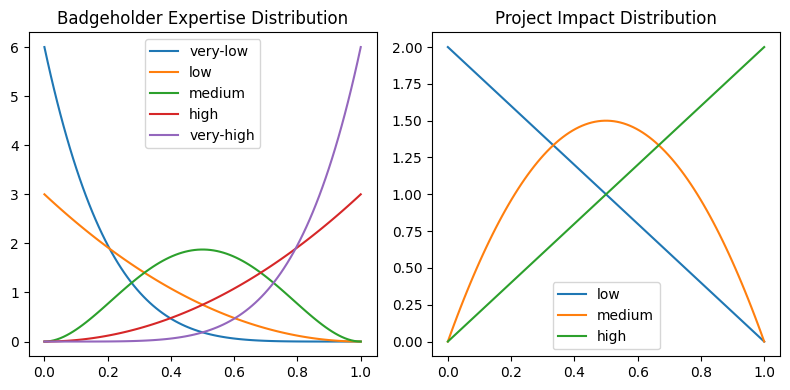

In [4]:
# lets plot the beta distributions pdfs to get a sense of what they look like
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
x = np.linspace(0, 1, 100)

for expertise, params in expertise2params.items():
    pdf = stats.beta.pdf(x, *params)
    ax[0].plot(x, pdf, label=expertise)
ax[0].legend()
ax[0].set_title('Badgeholder Expertise Distribution')

for impact, params in impact2params.items():
    pdf = stats.beta.pdf(x, *params)
    ax[1].plot(x, pdf, label=impact)
ax[1].legend()
ax[1].set_title('Project Impact Distribution')

plt.tight_layout()

In [5]:
# create the badgeholders
#  we create atleast 50 badgeholders so that the distribution of badgeholder expertise
#  roughly follows what we prescribe for the simulation
n = 50
badgeholder_list = []
for ii in range(n):
    badgeholder_id = ii
    expertise = rng.beta(*expertise2params[simulation_badgeholder_expertise])
    agent = PairwiseBadgeholder(
        badgeholder_id=badgeholder_id,
        voting_style='skewed_towards_impact',
        expertise=expertise
    )
    badgeholder_list.append(agent)
badgeholders = PairwiseBadgeholderPopulation()
badgeholders.add_badgeholders(badgeholder_list)

In [6]:
# create projects
N = 20
projects = []
for ii in range(N):
    project_id = ii
    project_impact = rng.beta(*impact2params[simulation_project_impact])
    project = Project(
        project_id=project_id,
        true_impact=project_impact,  
        owner_id=None,  # used for COI modeling
    )
    projects.append(project)
project_population = ProjectPopulation()
project_population.add_projects(projects)

In [7]:
fund_distribution_model = PairwiseBinary()

In [8]:
# create and run a simulation
simulation_obj = RoundSimulation(
    badgeholder_population=badgeholders,
    projects=project_population,
    funding_design=fund_distribution_model,
    random_seed=123
)
voting_view_ix = itertools.combinations(range(project_population.num_projects), 2)
voting_view = []
for ix1, ix2 in voting_view_ix:
    voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
simulation_obj.run(cast_votes_kwargs={'view': voting_view})

In [9]:
all_votes = simulation_obj.badgeholder_population.get_all_votes()

# make a matrix of all the pairwise voting possibilities
project_list = simulation_obj.projects.projects
N = len(project_list)
project_vote_matrix = np.zeros((N, N))
project2ix = {p:ix for ix, p in enumerate(project_list)}
vote_data_list = []

# put the votes into the matrix for analysis
for v in all_votes:
    ix1 = project2ix[v.project1]
    ix2 = project2ix[v.project2]
    project_vote_matrix[ix1, ix2] += v.val1
    project_vote_matrix[ix2, ix1] += v.val2

    if v.val1 > v.val2:
        vote_data_list.append((ix1, ix2))
    elif v.val2 > v.val1:
        vote_data_list.append((ix2, ix1))
    else:
        # TODO: not sure if there is a tie, is that even possible??
        print('In Tie scenario!')
        pass

In [10]:
# estimate parameters of bradley terry model
params = choix.ilsr_pairwise(N, vote_data_list)
# create rank order of project ids
project_ix_worst_to_best_inferred = np.argsort(params)
project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

In [11]:
# compare the inferred ranks to the actual ranks
actual_project_impacts = np.array([p.true_impact for p in project_list])
# rank them
project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

# compare the two
print('Actual Project Ranking by impact:', project_ix_worst_to_best_actual)
print('Inferred Project Ranking by impact:', project_ix_worst_to_best_inferred)

Actual Project Ranking by impact: [14  8  9  3 12  0  6  5 11 17 10  2 18 16 13  1  4 19  7 15]
Inferred Project Ranking by impact: [14  8  9  3 12  6  0  5 17 11 10  2 18 16 13 15 19  1  4  7]


In [12]:
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

In [13]:
min_swaps = min_swaps_to_sort(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
tau = stats.kendalltau(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred).correlation
print(min_swaps, tau)

6 0.2631578947368421


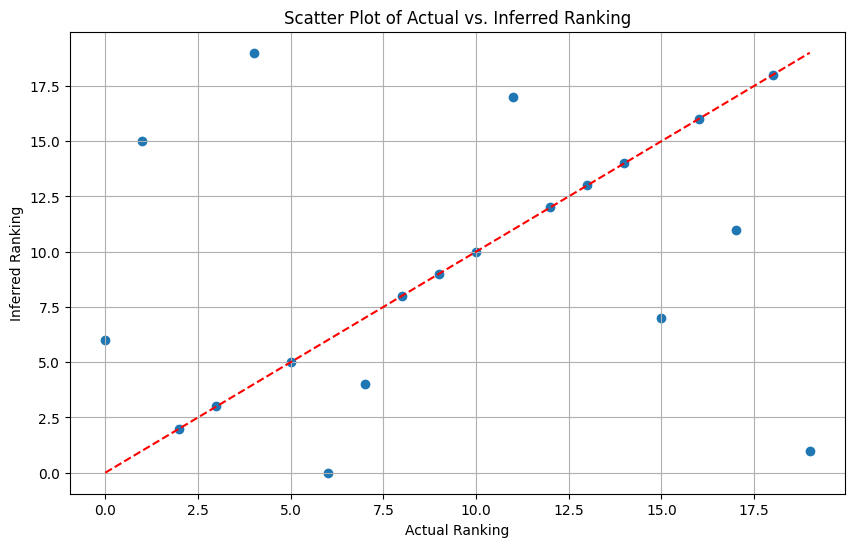

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
min_actual, max_actual = min(project_ix_worst_to_best_actual), max(project_ix_worst_to_best_actual)
min_inferred, max_inferred = min(project_ix_worst_to_best_inferred), max(project_ix_worst_to_best_inferred)
plt.plot([min_actual, max_actual], [min_inferred, max_inferred], 'r--')
plt.title("Scatter Plot of Actual vs. Inferred Ranking")
plt.xlabel("Actual Ranking")
plt.ylabel("Inferred Ranking")
plt.grid(True)
plt.show()

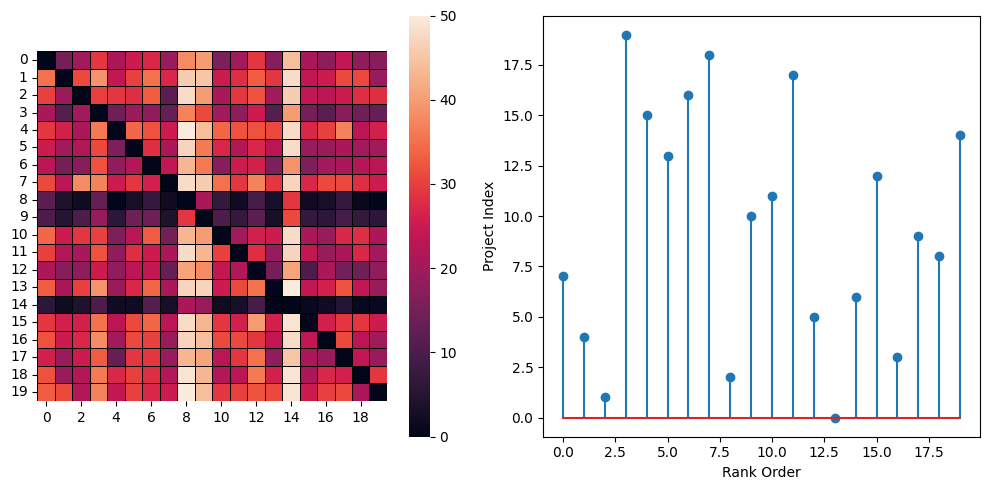

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(
    project_vote_matrix, 
    linewidths=0.5, 
    linecolor='black', 
    square=True,
    ax=ax[0]
)

ax[1].stem(project_ix_best_to_worst_inferred)
ax[1].set_ylabel('Project Index')
ax[1].set_xlabel('Rank Order')

plt.tight_layout()

In [16]:
## Links of interest:
#  1 - https://martiningram.github.io/mcmc-comparison/
#  2 - https://opisthokonta.net/?p=1589
